<a href="https://colab.research.google.com/github/M-Pascal/Chatbot_Summative/blob/main/Notebook/Healthcare_Chatbot_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DERMA_Chatbot using T5**
Within this task we will be building assistance chatbot which is fine-tune from pre-trained model using ```T5-small```. with the purpose of building a healthcare information chatbot that can answer patients’ questions especially about Skin disease information.

In [ ]:
# Installing transformers dependences
!pip install -U datasets
!pip install -U transformers
!!pip install -U evaluate
!pip install rouge_score
!pip install bert_score
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

# Importing Libraries

In [ ]:
# Importing necessary library
from datasets import load_dataset # for huggingface dataset
import re
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
import evaluate


# Loading and Cleaning Data

In [ ]:
# Loading the datset from Huggingface
data = load_dataset("Mreeb/Dermatology-Question-Answer-Dataset-For-Fine-Tuning")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/929 [00:00<?, ?B/s]

combined_data.csv:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1460 [00:00<?, ? examples/s]

In [ ]:
# Exploring data we downloaded
data

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'prompt_word_count', 'response_word_count'],
        num_rows: 1460
    })
})

In [ ]:
data.shape

{'train': (1460, 4)}

## Handling missing and Duplicate data

In [ ]:
# Handle cases where the split name might be different or missing
if 'train' in data:
    df = data['train'].to_pandas()
else:
    raise KeyError("Expected 'train' split not found in the dataset.")

# Showing initial row count
Init_Rows = len(df)
print("Initial rows:", Init_Rows)

# Check for missing values
missing_input = df['prompt'].isna().sum()
missing_output = df['response'].isna().sum()
print(f"Missing values on; input: {missing_input}, output: {missing_output}")

# Drop rows with missing input or output
df.dropna(subset=['prompt', 'response'], inplace=True)

# Checking for duplicates before dropping
duplicates = df.duplicated(subset=['prompt', 'response'], keep=False)
print(f"Number of duplicate rows (before drop): {duplicates.sum()}")

# Drop exact duplicate input-output pairs
df.drop_duplicates(subset=['prompt', 'response'], inplace=True)

# Final report
print("Cleaned data rows:", len(df))
print("Total rows removed during cleaning:", Init_Rows - len(df))

Initial rows: 1460
Missing values on; input: 0, output: 0
Number of duplicate rows (before drop): 0
Cleaned data rows: 1460
Total rows removed during cleaning: 0


## Data distribution visualization

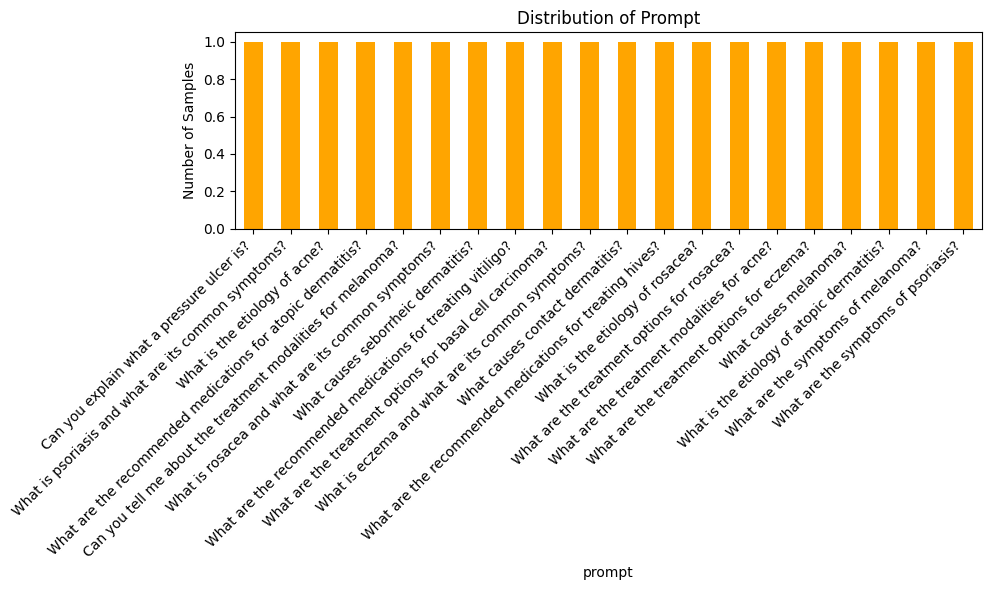

In [ ]:
from matplotlib import pyplot as plt

# Visualizing the most frequent asked questions in the dataset.
prompt_counts = df['prompt'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(10, 6))
prompt_counts.plot(kind='bar', color='orange')
plt.title('Distribution of Prompt')
plt.xlabel('prompt')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Visually confirms that a dataset where various dermatology-related medical questions (e.g., "What is the etiology of acne?") are listed on the x-axis. Crucially, every single prompt shown on the chart has an identical "Number of Samples" value of 1.0, indicated by all orange bars reaching the maximum height on the y-axis. This signifies a perfectly uniform distribution, meaning each medical question is equally represented within the sample set being displayed.

# Normalization

In [ ]:
# Normalize text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9\s.,?!]', '', text)
    return text.strip()

df['prompt'] = df['prompt'].apply(clean_text)
df['response'] = df['response'].apply(clean_text)

In [ ]:
df.head()

,prompt,response,prompt_word_count,response_word_count
0,what is psoriasis and what are its common symp...,psoriasis is a chronic autoimmune condition th...,9,67
1,what is the etiology of acne?,acne is primarily caused by the overproduction...,6,64
2,what are the recommended medications for atopi...,there are several medications available for th...,8,83
3,can you tell me about the treatment modalities...,melanoma treatment depends on the stage and lo...,10,101
4,what is rosacea and what are its common symptoms?,rosacea is a common skin condition that causes...,9,86


## Dataset splitting

In [ ]:
# Splitting 90% for training, 10% for validation
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Wrap in Dataset Dictionary
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Tokenization

In [ ]:
# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Preprocessing function
def preprocess(example):
    input_text = "question: " + example["prompt"]
    target_text = example["response"]

    model_inputs = tokenizer(input_text, max_length=128, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target_text, max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
tokenized_dataset = dataset.map(preprocess, remove_columns=["prompt", "response"])

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/1314 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/146 [00:00<?, ? examples/s]

# Model Training and Fine-Tuning

In [ ]:
# pretrained model
model = T5ForConditionalGeneration.from_pretrained("t5-small")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
from transformers import EarlyStoppingCallback

def train_and_evaluate(model, tokenized_data, learning_rate, output_dir,
                       num_train_epochs, per_device_train_batch_size, per_device_eval_batch_size, weight_decay):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=100,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_steps=200,
        save_total_limit=1,
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=2,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["validation"],
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    eval_loss = trainer.evaluate()["eval_loss"]
    return trainer, eval_loss

In [ ]:
# # Train baseline model
print("\nTraining baseline model: \n")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Baseline training
baseline_trainer, baseline_loss = train_and_evaluate(
    model=model,
    tokenized_data=tokenized_dataset,
    learning_rate=1e-3,
    output_dir="./results_baseline",
    weight_decay=0.01,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16
)


Training baseline model: 



Epoch,Training Loss,Validation Loss
1,3.273900,2.683876
2,2.699800,2.263369
3,2.401000,2.082432


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
# Training tuned model
print("\nTraining fine-tuned model with higher learning rate: \n")
tuned_trainer, tuned_loss = train_and_evaluate(
    model=model,
    tokenized_data=tokenized_dataset,
    learning_rate=3e-4,
    output_dir="./results_tuned_v2",
    weight_decay=0.01,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16
)


Training fine-tuned model with higher learning rate: 



Epoch,Training Loss,Validation Loss
1,2.236100,2.064935
2,2.058000,2.040557
3,2.183600,2.002059


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
# Printing results
print(f"\nLoss Comparison: ")
print(f"Baseline Loss : {baseline_loss:.4f}")
print(f"Fine-Tuned Loss : {tuned_loss:.4f}")


Loss Comparison: 
Baseline Loss : 2.0824
Fine-Tuned Loss : 2.0021


### Model Saving

In [ ]:
# Save model and tokenizer
save_dir = "./healthcare_chatbot_model"
tuned_trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

('./healthcare_chatbot_model/tokenizer_config.json',
 './healthcare_chatbot_model/special_tokens_map.json',
 './healthcare_chatbot_model/spiece.model',
 './healthcare_chatbot_model/added_tokens.json')

In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load your fine-tuned model
model = T5ForConditionalGeneration.from_pretrained("./healthcare_chatbot_model")
tokenizer = T5Tokenizer.from_pretrained("./healthcare_chatbot_model")

# Model Testing Queries

In [ ]:
# Define the chatbot function
def ask_bot(query):
    """
    Generate a clean, structured chatbot response using the fine-tuned healthcare model.
    """
    query_norm = query.strip().lower()
    input_text = f"question: {query_norm}"

    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

    # Set device and move model + inputs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate response
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=300,
            num_beams=4,
            repetition_penalty=3.0,
            no_repeat_ngram_size=3,
            early_stopping=True
        )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return f"Question: {query.strip()}\nResponse: {response}"

In [ ]:
# Queries for testing
test_queries = [
    "What are the recommended medications for eczema?",
    "What causes rosacea and how can it be treated?",
    "What is Atopic Dermatitis?"
]

for q in test_queries:
    print(ask_bot(q))
    print("-" * 50)

Question: What are the recommended medications for eczema?
Response: the recommended medications for eczema include 1. topical corticosteroids these are used to reduce inflammation and itching. 2. antihistamines these can help reduce inflammation, which can lead to redness, swelling, and blistering. 3. oral antibiotics these may be applied to the affected area of the skin or taken by a dermatologist. 4. immunoglobulin inhibitors this is a drug that can kill the immune system, leading to an increased risk of infection. 4. vitamin d c creams these
--------------------------------------------------
Question: What causes rosacea and how can it be treated?
Response: rosacea is a chronic skin condition that causes redness and swelling in the skin. it can also be caused by certain medications, such as antihistamines, corticosteroids, insect bites, pesticides, or other drugs. these include 1. topical antibiotics these are used to reduce inflammation and promote healthy skin cells. 2. oral anti

# Evaluation metric of Fine-Tuned model

In [ ]:
from tqdm import tqdm

# Load model & tokenizer
model = T5ForConditionalGeneration.from_pretrained("./healthcare_chatbot_model")
tokenizer = T5Tokenizer.from_pretrained("./healthcare_chatbot_model")

# Move model to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare small eval subset
eval_data = tokenized_dataset["validation"].select(range(130))

# Decode predictions and references
predictions = []
references = []

for sample in tqdm(eval_data):
    input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(device)

    with torch.no_grad():
        # Added attention_mask to the generate method
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Decode the labels for reference answers
    label = tokenizer.decode(sample["labels"], skip_special_tokens=True)


    predictions.append(pred)
    references.append(label)

100%|██████████| 130/130 [02:16<00:00,  1.05s/it]


In [ ]:
from evaluate import load

# Load the BERTScore evaluator
bertscore = load("bertscore")

# Compute BERTScore
results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en"
)

print(f"\n Mean BERTScore F1: {sum(results['f1']) / len(results['f1']):.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Mean BERTScore F1: 0.8565


In [ ]:
# Load other evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
f1_metric = evaluate.load("f1")

In [ ]:
# BLEU metrics
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
print(f"BLEU Score: {bleu_result['bleu']:.4f}")

# ROUGE metrics
rouge_result = rouge.compute(predictions=predictions, references=references)
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")

BLEU Score: 0.0711
ROUGE-L: 0.2181


In [ ]:
# # import trainer
# from transformers import Trainer

# # evaluating the perplexity of Fine tuned model
# trainer = Trainer(model=model)

# eval_results = trainer.evaluate()
# eval_loss = eval_results["eval_loss"]
# perplexity = torch.exp(torch.tensor(eval_loss))

# print(f"Eval Loss: {eval_loss:.4f}")
# print(f"Perplexity: {perplexity:.4f}")

In [ ]:
# Computing the F1_Score of the tuned model
nltk.download('punkt_tab')


def evaluate_F1_score(preds, refs):
    f1_scores = []

    for pred, ref in zip(preds, refs):
        pred_tokens = set(word_tokenize(pred.lower()))
        ref_tokens = set(word_tokenize(ref.lower()))

        common = pred_tokens.intersection(ref_tokens)
        if len(common) == 0:
            f1_scores.append(0)
            continue

        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

    return np.mean(f1_scores)

f1_text_score = evaluate_F1_score(predictions, references)
print(f"Text-overlap F1 Score: {f1_text_score:.3f}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Text-overlap F1 Score: 0.346


# Interface

In [ ]:
import gradio as gr

# Define the chatbot response function
def generate_response(query):
    if query.strip() == "":
        return "Please enter a question."
    return ask_bot(query)

# Gradio app using Blocks for custom layout
with gr.Blocks(title="DERMA Chatbot") as Demo_Interface:
    gr.Markdown("# Heart Disease Companion Chatbot.")
    gr.Markdown("Ask a question below and receive helpful information guidance about Heart disease with healthcare Companion ChatBot.")

    with gr.Row():
        with gr.Column():
            query_input = gr.Textbox(
                lines=2,
                label="Your Question",
                placeholder="Type your health-related question here..."
            )

            with gr.Row():
                submit_btn = gr.Button("Submit", variant="primary")
                cancel_btn = gr.Button("Cancel")

        with gr.Column():
            response_output = gr.Textbox(
                label="ChatBot Response",
                placeholder="Chatbot response here...",
                lines=4
            )

    # Define interactions
    submit_btn.click(
        fn=generate_response,
        inputs=query_input,
        outputs=response_output
    )

    cancel_btn.click(
        fn=lambda: ("", ""),
        inputs=[],
        outputs=[query_input, response_output]
    )

# Launch the app
Demo_Interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b9235d8e7efe4a307a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# ------------------------The End------------------------